In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
# ignore warnings
warnings.filterwarnings("ignore")

## Data
- Este Dataset utilizado refere-se ao consumo de energia por hora da costa leste dos EUA no período de 2002 - 2018 coordenado pela PJM ( Organização regional de transmissão )
- Usaremos esses dados para construir um modelo de séries temporais capaz de prever o comportamento do consumo de energia.

### Importando os dados

In [2]:
pjme = pd.read_csv('./input/PJME_hourly.csv', index_col=[0], parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


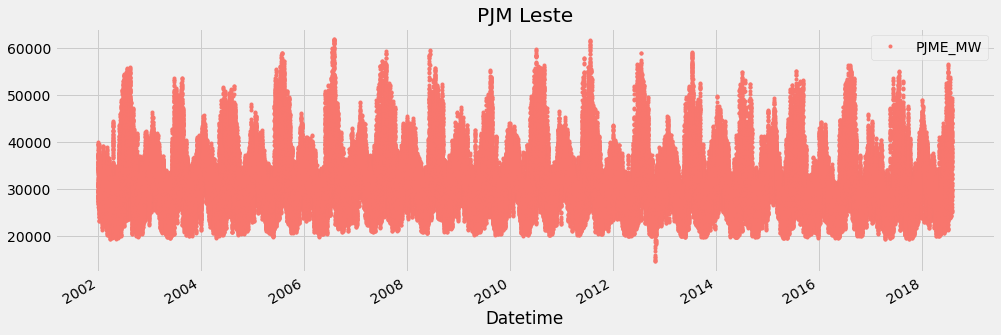

In [3]:
# Paleta de cores para plotagem
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM Leste')
plt.show()

### Divisão entre train e test
Dividindo os dados para que 2015 - 2018 sejam usados como validação

In [4]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

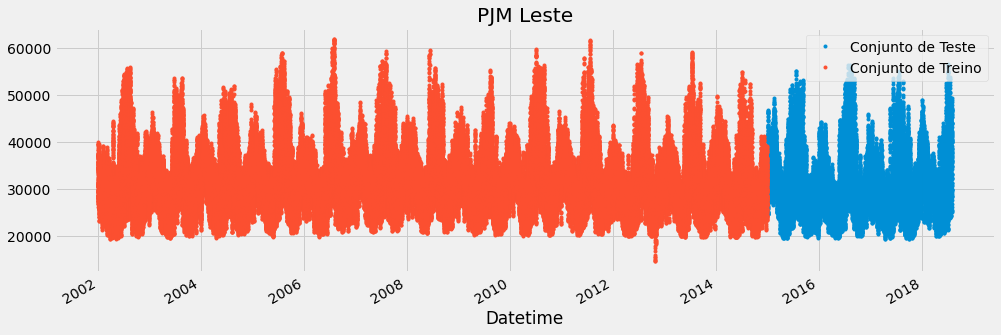

In [5]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'Conjunto de Teste'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'Conjunto de Treino'}), how='outer') \
    .plot(figsize=(15,5), title='PJM Leste', style='.')

## Criando recursos para série temporal

In [6]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [7]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

## Modelando ( Xgboost )

In [8]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## 'Importância dos recursos'
- É um bom ponto de início para verificar em quais recursos o modelo está se baseando mais para fazer as predições.

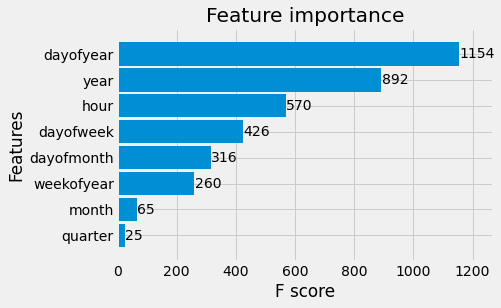

In [9]:
_ = plot_importance(reg, height=0.9)

## Previsão no conjunto de teste

In [10]:
pjme_test['MW_Previsão'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

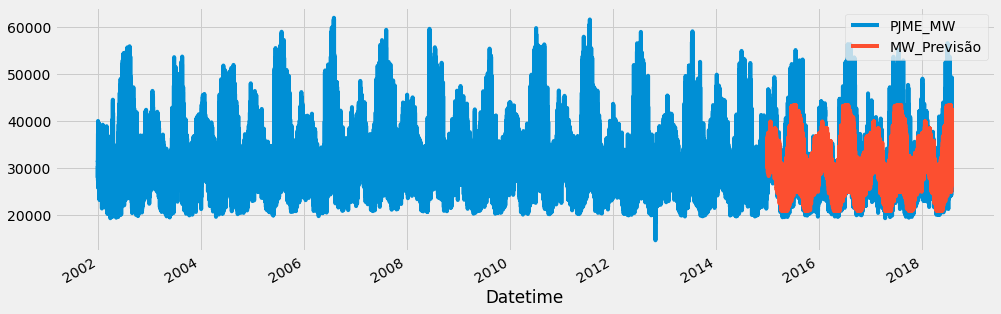

In [11]:
_ = pjme_all[['PJME_MW','MW_Previsão']].plot(figsize=(15, 5))

## Olhando para o primeiro mês de previsões

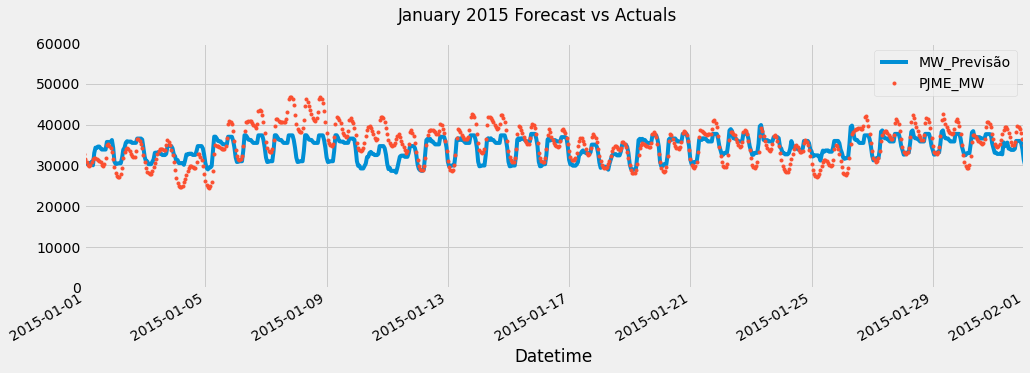

In [12]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Previsão','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

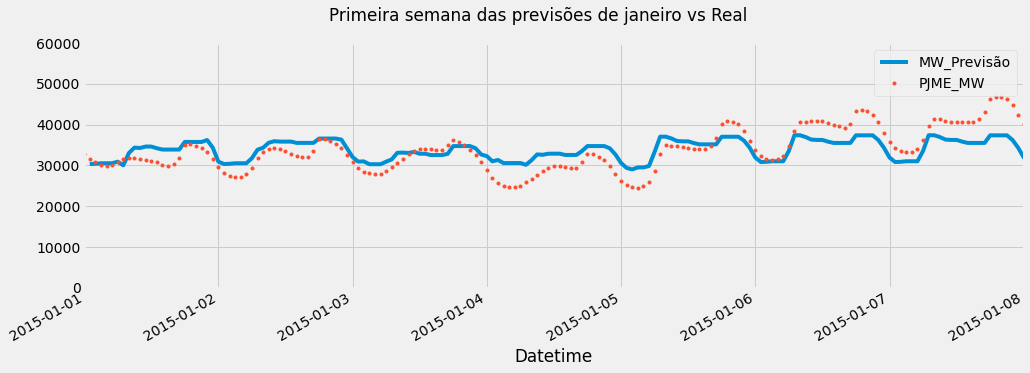

In [13]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Previsão','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('Primeira semana das previsões de janeiro vs Real')

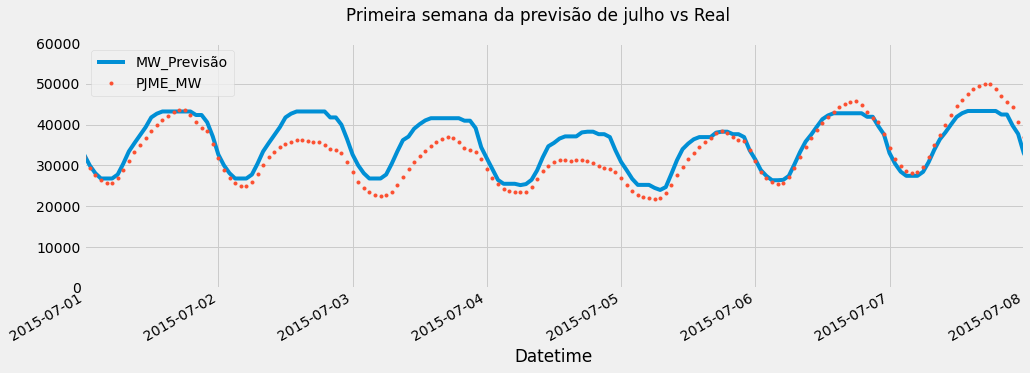

In [14]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Previsão','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('Primeira semana da previsão de julho vs Real')

In [17]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Previsão'])

13960913.30565261

In [19]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Previsão'])

2757.2169004982866

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are. MAPE isn't included in sklearn so we need to use a custom function.

In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Previsão'])

8.510847348494002

### Métricas de erro no conjunto de teste
- RMSE error 13960913
- MAE error 2757.21
- MAPE error 8.51%

# Segunda Abordagem

### Processo Estacionário
- Iremos realizar um teste chamado ADF (do inglês Augmented Dicky Fuller Test) para checar se essa série temporal possui indícios estacionariedade
- Caso não, iremos realizar transformações afim de tornar-la estacionária. Isso tornará o processo de modelagem mais fácil, pois alguns métodos requerem ou assumem que a série temporal seja estacionária

In [23]:
ts = pjme.PJME_MW.values

In [24]:
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
# Teste para estacionariedade
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(pjme.PJME_MW.values)

Results of Dickey-Fuller Test:
Test Statistic                -1.882891e+01
p-value                        2.022125e-30
#Lags Used                     7.400000e+01
Number of Observations Used    1.452910e+05
Critical Value (1%)           -3.430395e+00
Critical Value (5%)           -2.861560e+00
Critical Value (10%)          -2.566781e+00
dtype: float64


- Porque o nosso p-value é menor que é 0.05, podemos considerar que a nossa série temporal é estacionária

## Modelos AR, MA e ARMA

- AR:
    - O erro (diferença na média) do próximo valor é uma função dos erros dos n valores anteriores.
- MA:
    - O próximo valor da série é uma função da média dos n valores anteriores
- ARMA:
    - Uma mistura dos dois.
- Afim de verificar se a série temporal se encontra em um processo de AR ou MA, usamos:
    

In [25]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

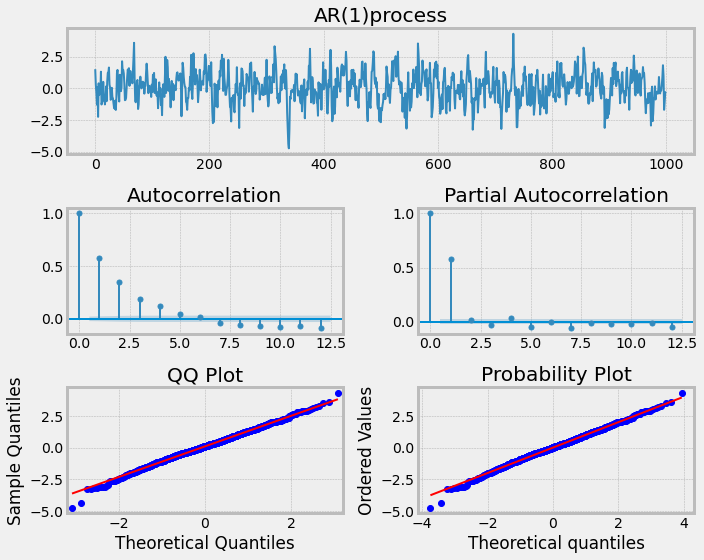

In [26]:
# Simulandoo um processo AR(1) com alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

## Processo AR(1) -- tem ACF decaindo e PACF zerando em lag=1

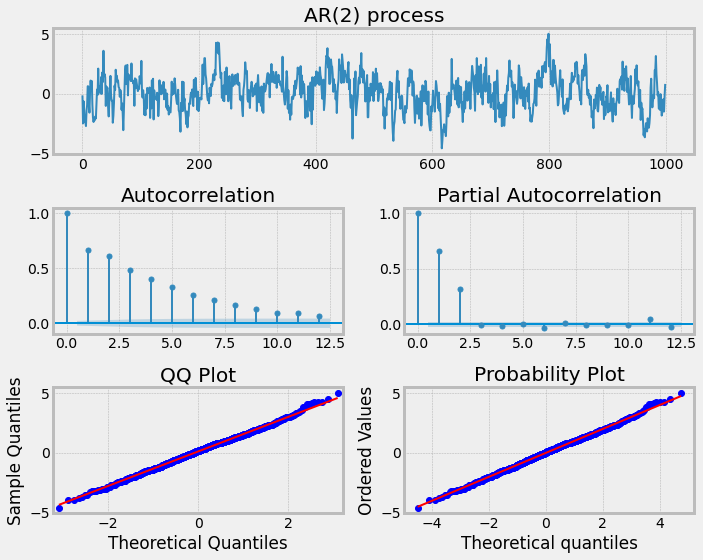

In [27]:
# Simulando um processo AR(2)

n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

## Processo AR(2) -- tem ACF decaindo e PACF zerando em lag=2

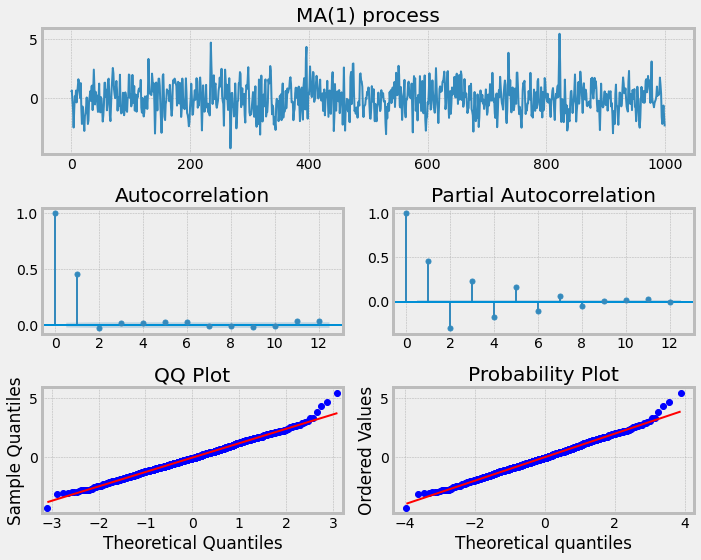

In [28]:
# Simulando um processo MA(1)
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

## Processo MA(1)-- tem ACF zerando em lag=1

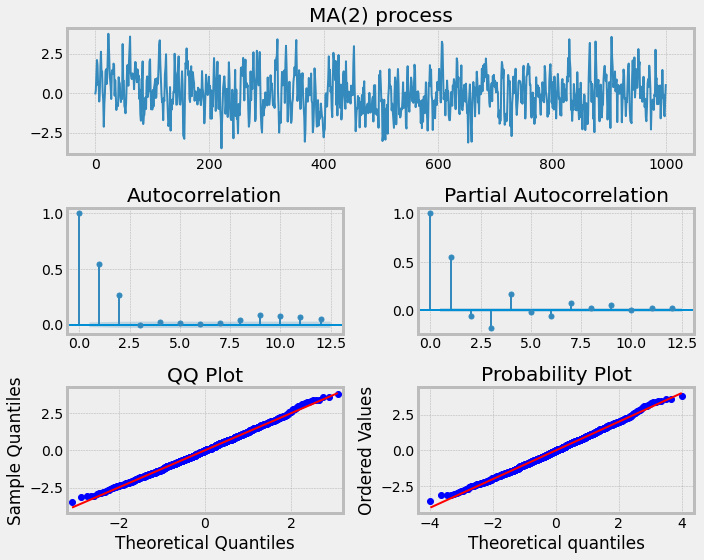

In [29]:
# Simulando um processo MA(2) com betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

## Processo MA(2) -- tem ACF zerando em lag=2

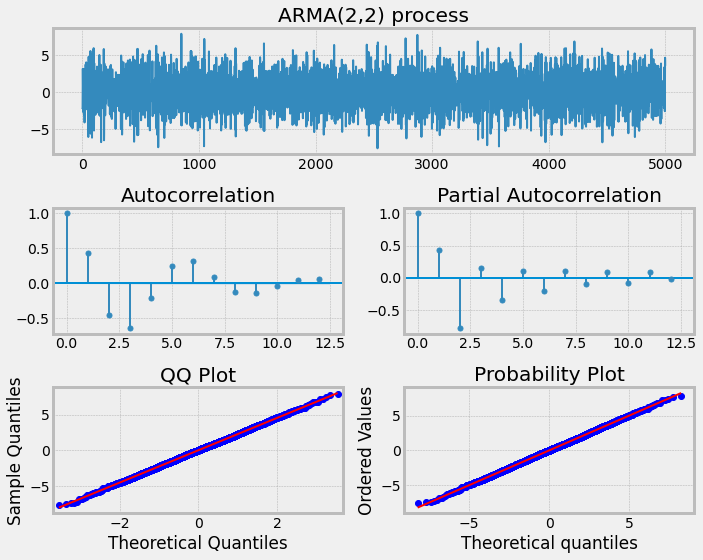

In [30]:
# Simulando um modelo ARMA(2, 2)com alphas=[0.5,-0.25] e betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # Muitas amostras para ajudar a estimar
burn = int(n/10) # número de amostras para descartar antes de alimentar o modelo

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

### Agora, usando uma abordagem sistemática para identificar a ordem dos processo AR e MA

In [31]:
# selecionar a melhor por ordem de 'aic'
# menor valor de 'aic' vence
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 15326.68109 | order: (2, 2)


#### Identificamos então a ordem do processo como sendo ARMA de ordem (2,2)